# Artifact rejection

This notebook demonstrates how to perform automatic artifact rejection in YASA, specifically to detect major body movements on single or multi-channel data.

Please make sure to install the latest version of YASA first with: `pip install --upgrade yasa`

To start with, let's load a full night recording of EEG data (9 channels), sampled at 100 Hz and staged.

In [1]:
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.2)

# Load data
f = np.load('data_full_6hrs_100Hz_9channels.npz')
data= f['data']
chan = ['Fz', 'F3', 'F4', 'Cz', 'C3', 'C4', 'Pz', 'P3', 'P4']
sf = 100.
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')
times = np.arange(data.size) / sf

print(data.shape)
print(chan)
print(np.round(data[:, 0:5], 3))

(9, 2161058)
['Fz', 'F3', 'F4', 'Cz', 'C3', 'C4', 'Pz', 'P3', 'P4']
[[20.963 30.527 45.829 29.15  31.751]
 [ 1.527 12.594 37.552 11.296 16.334]
 [15.797 22.307 39.922 25.657 27.094]
 [28.573 39.195 48.994 33.361 37.699]
 [-3.08   6.971 26.262  3.323  9.078]
 [16.896 26.385 40.966 21.833 24.456]
 [11.759 17.329 35.664 25.762 26.536]
 [ 4.069 10.635 35.882 18.311 18.958]
 [ 5.899 14.297 36.592 26.094 23.395]]


In [2]:
# For the sake of the example, let's add some flat data (e.g. disconnected) at the end
data = np.concatenate((data, np.zeros((data.shape[0], 20000))), axis=1)
hypno = np.concatenate((hypno, np.zeros(20000)))
data.shape, hypno.shape

((9, 2181058), (2181058,))

/Users/raphael/GitHub/yasa/yasa/plotting.py:263: RuntimeWarning: divide by zero encountered in log10
  Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz


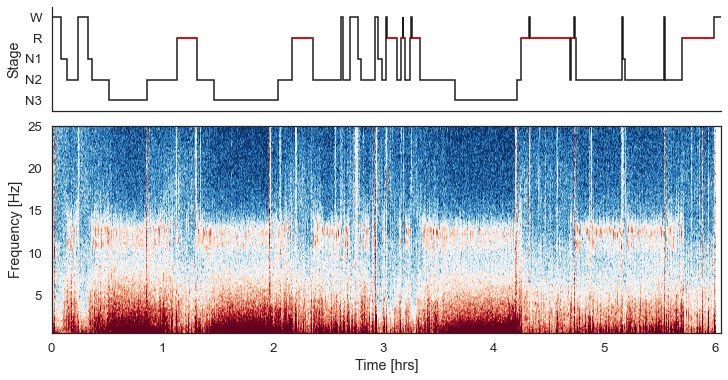

In [3]:
# Plot hypnogram and spectrogram on Fz
# We should see a warning because of the flat data at the end
yasa.plot_spectrogram(data[0, :], sf, hypno);

***************

## 1. Artifact rejection without using the hypnogram

### 1.1. Covariance-based rejection

The default method implemented in YASA is a multivariate approach based on covariance matrices. Briefly, the main idea of this approach is to estimate a reference covariance matrix of "clean data" $\bar{C}$ and reject every epoch which is too far from this reference covariance matrix. The distance of the covariance matrix of the current epoch $C$ from the reference matrix $\bar{C}$ is calculated using Riemannian geometry, which is more adapted than Euclidean geometry for symmetric positive definite covariance matrices:

<center>$d = {\left( \sum_i \log(\lambda_i)^2 \right)}^{-1/2}$</center><br>

where $\lambda_i$ are the joint eigenvalues of $C$ and $\bar{C}$. The epoch with covariance matric $C$ will be marked as an artifact if the distance $d$ is greater than a threshold $T$ (typically 2 or 3 standard deviations). $\bar{C}$ is iteratively estimated using a clustering approach. This function is essentially a wrapper around the [Potato class](https://pyriemann.readthedocs.io/en/latest/generated/pyriemann.clustering.Potato.html#pyriemann.clustering.Potato) in the pyRiemann library.


**The pros of this approach are:**

- Multivariate approach that takes into account the variance in each channel as well as the inter-relationship between all channels (covariance) to define artifacts
- Robust to noise

**The cons:**

- Do not work with single-channel data. YASA requires at least 4 channels to use this method.
- High computation time, especially with epochs smaller than 5-seconds, or very long datasets, or data with a very high sampling frequency (> 500 Hz). We recommend downsampling your data to 100 or 200 Hz prior to using this function.
- Based on the assumption that most of the data is clean; otherwise the reference matrix will be biased. We recommend that you visually exclude any bad channels prior to using this function.


**For more details please refer to**

- Barachant, Andreev, & Congedo. (2013). [The Riemannian
    Potato: an automatic and adaptive artifact detection method for online
    experiments using Riemannian geometry](https://hal.archives-ouvertes.fr/hal-00781701/). *TOBI Workshop lV, 19–20.*
- Barthélemy, Mayaud, Ojeda, & Congedo. (2019).
    [The Riemannian Potato Field: A Tool for Online Signal Quality Index of
    EEG](https://doi.org/10.1109/TNSRE.2019.2893113). *IEEE Transactions on Neural Systems and Rehabilitation Engineering:
    27(2), 244–255.*
- https://pyriemann.readthedocs.io/en/latest/index.html

In [4]:
art, zscores = yasa.art_detect(data, sf, window=5, method='covar', threshold=3)
art.shape, zscores.shape

((4362,), (4362,))

In [5]:
# Art is an aray of 0 and 1, where 0 indicates a clean (or good epoch)  and 1 indicates an artifact epoch
print(art)
print(f'{art.sum()} / {art.size} epochs rejected.')

[False False False ...  True  True  True]
100 / 4362 epochs rejected.


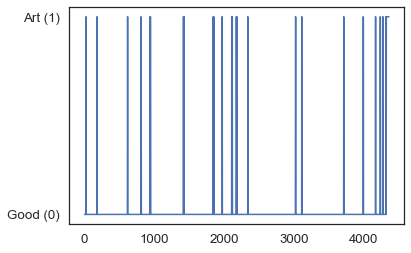

In [6]:
# Plot the artifact vector
plt.plot(art);
plt.yticks([0, 1], labels=['Good (0)', 'Art (1)']);

**Plot the distribution of z-scores**

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


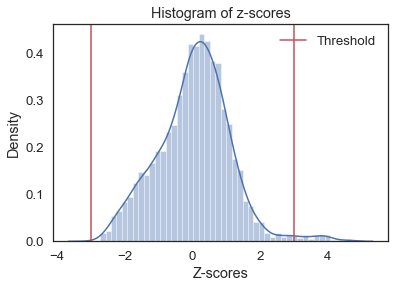

In [7]:
sns.distplot(zscores)
plt.title('Histogram of z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Density')
plt.axvline(3, color='r', label='Threshold')
plt.axvline(-3, color='r')
plt.legend(frameon=False);

Given a threshold defined in the number of standard deviations from the mean, the proportion of samples that will be outside the range (e.g. rejected) is defined as $1 - \text{erf}\left ( \frac{z}{\sqrt{2}}\right )$. For more details, see https://en.wikipedia.org/wiki/Standard_deviation#Rules_for_normally_distributed_data

In [8]:
from scipy.special import erf
threshold = 3
perc_expected_rejected = (1 - erf(threshold / np.sqrt(2))) * 100
print(f'{perc_expected_rejected:.2f}% of all epochs are expected to be rejected.')

0.27% of all epochs are expected to be rejected.


In [9]:
# Actual
(art.sum() / art.size) * 100
print(f'{(art.sum() / art.size) * 100:.2f}% of all epochs were actually rejected.')

2.29% of all epochs were actually rejected.


**Merge the artifact vector with the hypnogram**

In [10]:
# The resolution of art is 5 seconds, so its sampling frequency is 1/5 (= 0.2 Hz)
sf_art = 1 / 5
art_up = yasa.hypno_upsample_to_data(art, sf_art, data, sf)
art_up.shape, hypno.shape

04-Dec-22 10:03:35 | WARNING | Hypnogram is SHORTER than data by 0.58 seconds. Padding hypnogram with last value to match data.size.


((2181058,), (2181058,))

Now that `hypno` and `art_up` have the same size, we can easily merge them. Below, we mark as artifact (code = -1) all the 5-seconds epochs that were automatically rejected:

In [11]:
# Add -1 to hypnogram where artifacts were detected
hypno_with_art = hypno.copy()
hypno_with_art[art_up] = -1

# Proportion of each stage in ``hypno_with_art``
pd.Series(hypno_with_art).value_counts(normalize=True)

 2.0    0.431847
 3.0    0.243036
 4.0    0.216610
 0.0    0.055325
 1.0    0.030230
-1.0    0.022951
dtype: float64

/Users/raphael/GitHub/yasa/yasa/plotting.py:263: RuntimeWarning: divide by zero encountered in log10
  Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz


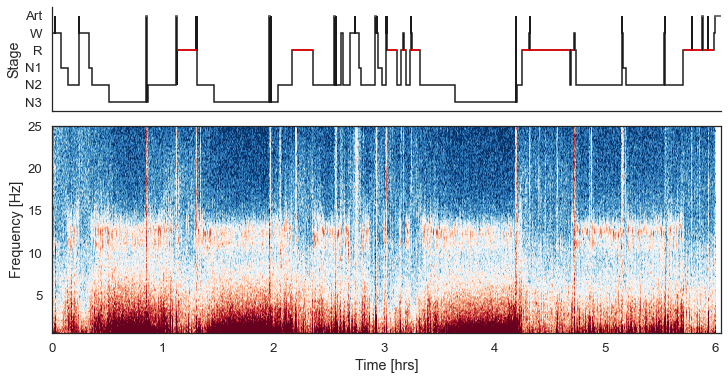

In [12]:
# Plot new hypnogram and spectrogram on Fz
yasa.plot_spectrogram(data[0, :], sf, hypno_with_art);

### 1.2. Standard-deviation based rejection

The second method implemented in YASA is a much faster and straightforward approach which is simply based on the distribution of the standard deviations of each epoch. Specifically, one first calculate the standard deviations of each epoch and each channel. Then, the resulting array of standard deviations is log-transformed and z-scored. Any epoch with one or more channel exceeding the threshold will be marked as artifact.

Note that this approach is more sensitive to noise and/or the influence of one bad channel (e.g. electrode fell off at some point during the night). We therefore recommend that you visually inspect and remove any bad channels prior to using this function.

In [13]:
# Apply the artifact rejection with method='std'
# In order to have more details on the artifact rejection, one can set the
# logging level to INFO
art_std, zscores_std = yasa.art_detect(data, sf, window=5, method='std', threshold=3, verbose='info')
art_std.shape, zscores_std.shape

04-Dec-22 10:03:36 | INFO | Number of samples in data = 2181058
04-Dec-22 10:03:36 | INFO | Sampling frequency = 100.00 Hz
04-Dec-22 10:03:36 | INFO | Data duration = 21810.58 seconds
04-Dec-22 10:03:36 | INFO | Trimmed standard deviation of CHAN000 = 20.6485 uV
04-Dec-22 10:03:36 | INFO | Peak-to-peak amplitude of CHAN000 = 4660.3770 uV
04-Dec-22 10:03:36 | INFO | Trimmed standard deviation of CHAN001 = 17.9120 uV
04-Dec-22 10:03:36 | INFO | Peak-to-peak amplitude of CHAN001 = 4069.6061 uV
04-Dec-22 10:03:36 | INFO | Trimmed standard deviation of CHAN002 = 23.5062 uV
04-Dec-22 10:03:36 | INFO | Peak-to-peak amplitude of CHAN002 = 4851.8518 uV
04-Dec-22 10:03:36 | INFO | Trimmed standard deviation of CHAN003 = 27.3139 uV
04-Dec-22 10:03:36 | INFO | Peak-to-peak amplitude of CHAN003 = 3987.3490 uV
04-Dec-22 10:03:36 | INFO | Trimmed standard deviation of CHAN004 = 20.1100 uV
04-Dec-22 10:03:36 | INFO | Peak-to-peak amplitude of CHAN004 = 3914.2716 uV
04-Dec-22 10:03:36 | INFO | Trimmed 

((4362,), (4362, 9))

In [14]:
# When method='std', zscores is an array of shape (n_epochs, n_chan). 
# Notice the np.nan at the end of the data that corresponds to flat epochs
zscores_std

array([[-0.93850175, -1.03325305, -1.31413914, ..., -1.01438553,
        -1.11122032, -1.11083162],
       [-0.6637989 , -0.42282164, -1.1722693 , ..., -0.60194675,
        -0.72830826, -0.62726795],
       [-1.36069644, -1.16359489, -1.71304407, ..., -1.28683142,
        -1.41654985, -1.37795803],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [15]:
# We can average the z-scores across all channels
avg_zscores = zscores_std.mean(-1)
avg_zscores

array([-1.03685734, -0.63156825, -1.34753832, ...,         nan,
               nan,         nan])

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


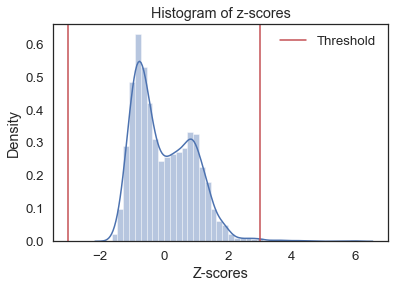

In [16]:
# And check the distribution
sns.distplot(avg_zscores)
plt.title('Histogram of z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Density')
plt.axvline(3, color='r', label='Threshold')
plt.axvline(-3, color='r')
plt.legend(frameon=False);

In [17]:
print(f'The correlation between the two methods is r = {np.corrcoef(art, art_std)[0, 1]:.2f}')

The correlation between the two methods is r = 0.88


***************

## 2. Artifact rejection with the hypnogram

Sleep stages have very different EEG signatures, and the stage-agnostic artifact rejection that we've applied so far may incorrectly reject epochs that are simply belonging to a different sleep stage because the covariance matrices will look very different. A much better approach is to apply the artifact rejection on pre-staged data. In the section below, we demonstrate how tu run the artifact rejection with an hypnogram in order to apply the artifact rejection separately for each sleep stage.

### 2.1. Covariance-based rejection

Concretely, what it means for the covariance-based method is that the reference covariance matrix will be estimated separately for each sleep stage, provided that at least 30 epochs of the current stage are present in data (which amounts to 2.5 minutes when using 5-seconds epochs).

In [18]:
art, zscores = yasa.art_detect(data, sf, window=5, hypno=hypno, include=(1, 2, 3, 4), 
                               method='covar', threshold=3, verbose='info')
art.shape, zscores.shape

04-Dec-22 10:03:37 | INFO | Number of unique values in hypno = 5
04-Dec-22 10:03:37 | INFO | Number of samples in data = 2181058
04-Dec-22 10:03:37 | INFO | Sampling frequency = 100.00 Hz
04-Dec-22 10:03:37 | INFO | Data duration = 21810.58 seconds
04-Dec-22 10:03:37 | INFO | Trimmed standard deviation of CHAN000 = 20.6485 uV
04-Dec-22 10:03:37 | INFO | Peak-to-peak amplitude of CHAN000 = 4660.3770 uV
04-Dec-22 10:03:37 | INFO | Trimmed standard deviation of CHAN001 = 17.9120 uV
04-Dec-22 10:03:37 | INFO | Peak-to-peak amplitude of CHAN001 = 4069.6061 uV
04-Dec-22 10:03:37 | INFO | Trimmed standard deviation of CHAN002 = 23.5062 uV
04-Dec-22 10:03:37 | INFO | Peak-to-peak amplitude of CHAN002 = 4851.8518 uV
04-Dec-22 10:03:37 | INFO | Trimmed standard deviation of CHAN003 = 27.3139 uV
04-Dec-22 10:03:37 | INFO | Peak-to-peak amplitude of CHAN003 = 3987.3490 uV
04-Dec-22 10:03:37 | INFO | Trimmed standard deviation of CHAN004 = 20.1100 uV
04-Dec-22 10:03:37 | INFO | Peak-to-peak amplitu

((4362,), (4362,))

04-Dec-22 10:03:51 | WARNING | Hypnogram is SHORTER than data by 0.58 seconds. Padding hypnogram with last value to match data.size.
/Users/raphael/GitHub/yasa/yasa/plotting.py:263: RuntimeWarning: divide by zero encountered in log10
  Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz


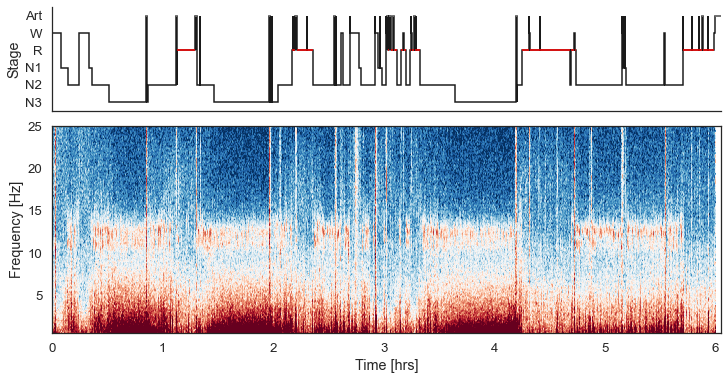

In [19]:
art_up = yasa.hypno_upsample_to_data(art, sf_art, data, sf)

# Add -1 to hypnogram where artifacts were detected
hypno_with_art = hypno.copy()
hypno_with_art[art_up] = -1

yasa.plot_spectrogram(data[0, :], sf, hypno_with_art);

### 1.2. Standard-deviation based rejection

In [20]:
art_std, zscores_std = yasa.art_detect(data, sf, window=5, hypno=hypno, include=(1, 2, 3, 4), 
                                       method='std', threshold=3, verbose='info')

art_std.shape, zscores_std.shape

04-Dec-22 10:03:52 | INFO | Number of unique values in hypno = 5
04-Dec-22 10:03:52 | INFO | Number of samples in data = 2181058
04-Dec-22 10:03:52 | INFO | Sampling frequency = 100.00 Hz
04-Dec-22 10:03:52 | INFO | Data duration = 21810.58 seconds
04-Dec-22 10:03:52 | INFO | Trimmed standard deviation of CHAN000 = 20.6485 uV
04-Dec-22 10:03:52 | INFO | Peak-to-peak amplitude of CHAN000 = 4660.3770 uV
04-Dec-22 10:03:52 | INFO | Trimmed standard deviation of CHAN001 = 17.9120 uV
04-Dec-22 10:03:52 | INFO | Peak-to-peak amplitude of CHAN001 = 4069.6061 uV
04-Dec-22 10:03:52 | INFO | Trimmed standard deviation of CHAN002 = 23.5062 uV
04-Dec-22 10:03:52 | INFO | Peak-to-peak amplitude of CHAN002 = 4851.8518 uV
04-Dec-22 10:03:52 | INFO | Trimmed standard deviation of CHAN003 = 27.3139 uV
04-Dec-22 10:03:52 | INFO | Peak-to-peak amplitude of CHAN003 = 3987.3490 uV
04-Dec-22 10:03:52 | INFO | Trimmed standard deviation of CHAN004 = 20.1100 uV
04-Dec-22 10:03:52 | INFO | Peak-to-peak amplitu

((4362,), (4362, 9))

04-Dec-22 10:03:53 | WARNING | Hypnogram is SHORTER than data by 0.58 seconds. Padding hypnogram with last value to match data.size.
/Users/raphael/GitHub/yasa/yasa/plotting.py:263: RuntimeWarning: divide by zero encountered in log10
  Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz


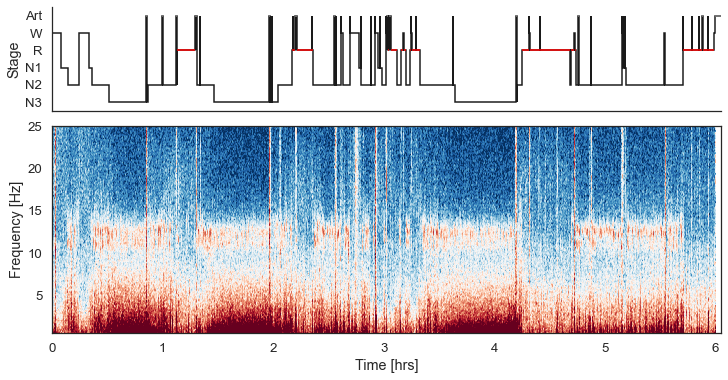

In [21]:
art_up = yasa.hypno_upsample_to_data(art_std, sf_art, data, sf)

# Add -1 to hypnogram where artifacts were detected
hypno_with_art = hypno.copy()
hypno_with_art[art_up] = -1

yasa.plot_spectrogram(data[0, :], sf, hypno_with_art);

In [22]:
print(f'The correlation between the two methods is r = {np.corrcoef(art, art_std)[0, 1]:.2f}')

The correlation between the two methods is r = 0.89


We can also apply a more conservative detection by specifying the number of channels that must be above or below threshold for the epoch to be marked as an artifact. In the code below, `n_chan_reject = 2` means that at least 2 channels must be above or below the threshold for the epoch to be marked as an artifact.

In [23]:
art_std, zscores_std = yasa.art_detect(data, sf, window=5, hypno=hypno, include=(1, 2, 3, 4), 
                                       method='std', threshold=3, n_chan_reject=2, verbose='info')

04-Dec-22 10:03:54 | INFO | Number of unique values in hypno = 5
04-Dec-22 10:03:54 | INFO | Number of samples in data = 2181058
04-Dec-22 10:03:54 | INFO | Sampling frequency = 100.00 Hz
04-Dec-22 10:03:54 | INFO | Data duration = 21810.58 seconds
04-Dec-22 10:03:54 | INFO | Trimmed standard deviation of CHAN000 = 20.6485 uV
04-Dec-22 10:03:54 | INFO | Peak-to-peak amplitude of CHAN000 = 4660.3770 uV
04-Dec-22 10:03:54 | INFO | Trimmed standard deviation of CHAN001 = 17.9120 uV
04-Dec-22 10:03:54 | INFO | Peak-to-peak amplitude of CHAN001 = 4069.6061 uV
04-Dec-22 10:03:54 | INFO | Trimmed standard deviation of CHAN002 = 23.5062 uV
04-Dec-22 10:03:54 | INFO | Peak-to-peak amplitude of CHAN002 = 4851.8518 uV
04-Dec-22 10:03:54 | INFO | Trimmed standard deviation of CHAN003 = 27.3139 uV
04-Dec-22 10:03:54 | INFO | Peak-to-peak amplitude of CHAN003 = 3987.3490 uV
04-Dec-22 10:03:54 | INFO | Trimmed standard deviation of CHAN004 = 20.1100 uV
04-Dec-22 10:03:54 | INFO | Peak-to-peak amplitu